### Load the required Python libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pwlf
import holidays
import random
import datetime
from scipy import optimize
import time
pd.options.mode.chained_assignment = None

# Residential Load Data
## Step 1) Load it into memory
This is a large file. We're going to tell Python in advance which datatypes to expect in each column. This will reduce the amount of required memory. More on that later.


In [2]:
column_types = {   'CONFIDENTIAL': 'category',
    'PVSS': 'float32',
    'HOUR_1': 'float32',
    'HOUR_10': 'float32',
    'HOUR_11': 'float32',
    'HOUR_12': 'float32',
    'HOUR_13': 'float32',
    'HOUR_14': 'float32',
    'HOUR_15': 'float32',
    'HOUR_16': 'float32',
    'HOUR_17': 'float32',
    'HOUR_18': 'float32',
    'HOUR_19': 'float32',
    'HOUR_2': 'float32',
    'HOUR_20': 'float32',
    'HOUR_21': 'float32',
    'HOUR_22': 'float32',
    'HOUR_23': 'float32',
    'HOUR_24': 'float32',
    'HOUR_3': 'float32',
    'HOUR_4': 'float32',
    'HOUR_5': 'float32',
    'HOUR_6': 'float32',
    'HOUR_7': 'float32',
    'HOUR_8': 'float32',
    'HOUR_9': 'float32',
    'ID': 'int64',
    'REGION4': 'category',
    'SITECODE': 'category'}

df = pd.read_csv('./Data/BC_RESIDENTIAL_LOAD_DATA.csv',dtype=column_types)

In [3]:
df.head()

,Unnamed: 0,CONFIDENTIAL,ID,REGION4,SITECODE,DATE,HOUR_1,HOUR_2,HOUR_3,HOUR_4,...,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23,HOUR_24
0,0,CONFIDENTIAL - BC HYDRO,1,VI,Residential - Single/Duplex (Elec Heat),2015-11-01,1.364,1.360,1.341,1.398,...,4.346,2.626,2.215,2.582,3.280,2.738,6.228,4.843,1.878,1.791
1,1,CONFIDENTIAL - BC HYDRO,1,VI,Residential - Single/Duplex (Elec Heat),2015-11-02,1.584,2.186,1.806,1.736,...,2.197,2.225,1.578,1.857,1.719,10.462,2.958,5.531,3.488,4.864
2,2,CONFIDENTIAL - BC HYDRO,1,VI,Residential - Single/Duplex (Elec Heat),2015-11-03,1.685,1.539,1.325,2.788,...,4.729,1.827,2.094,5.998,3.027,5.289,2.246,3.609,1.527,1.088
3,3,CONFIDENTIAL - BC HYDRO,1,VI,Residential - Single/Duplex (Elec Heat),2015-11-04,1.430,0.983,1.172,1.104,...,2.046,2.216,2.854,4.930,2.398,5.832,2.052,7.605,7.109,4.177
4,4,CONFIDENTIAL - BC HYDRO,1,VI,Residential - Single/Duplex (Elec Heat),2015-11-05,1.267,1.349,1.105,1.638,...,3.385,2.574,2.284,2.609,3.255,3.889,5.039,6.108,3.136,2.602


First, notice how the entries for the SITECODE column are long descriptive strings, e.g. "Residential - Single/Duplex (Elec Heat)". Saving this as a string data type would require lots of memory (taking into account the 1000s of rows). Instead, we told Python to save it as a 'category'. This essentially creates a table mapping the few number of SITECODES (I think there are 10 unique sitecodes) to the entries. So each SITECODE in the dataframe is actually represented by three bits. Much more efficient! You'll see in the following cell that it is in fact 100x more space efficient. You can read more about that online.


In [4]:
m1 = df['SITECODE'].memory_usage(deep=True)
m2 = df['SITECODE'].astype('string').memory_usage(deep=True)
print(m2/m1)

99.91546215580627



### Next, we want to clean up the table. Let's delete the first two columns and case the DATE column to a datetime datatype. 

In [5]:
df = df.drop(columns=['Unnamed: 0', 'CONFIDENTIAL'])
df = df.rename(columns={"REGION4":"REGION"})
df['DATE'] = pd.to_datetime(df.DATE)
df.head()

,ID,REGION,SITECODE,DATE,HOUR_1,HOUR_2,HOUR_3,HOUR_4,HOUR_5,HOUR_6,...,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23,HOUR_24
0,1,VI,Residential - Single/Duplex (Elec Heat),2015-11-01,1.364,1.360,1.341,1.398,1.471,1.726,...,4.346,2.626,2.215,2.582,3.280,2.738,6.228,4.843,1.878,1.791
1,1,VI,Residential - Single/Duplex (Elec Heat),2015-11-02,1.584,2.186,1.806,1.736,1.719,1.938,...,2.197,2.225,1.578,1.857,1.719,10.462,2.958,5.531,3.488,4.864
2,1,VI,Residential - Single/Duplex (Elec Heat),2015-11-03,1.685,1.539,1.325,2.788,4.518,2.084,...,4.729,1.827,2.094,5.998,3.027,5.289,2.246,3.609,1.527,1.088
3,1,VI,Residential - Single/Duplex (Elec Heat),2015-11-04,1.430,0.983,1.172,1.104,1.236,1.556,...,2.046,2.216,2.854,4.930,2.398,5.832,2.052,7.605,7.109,4.177
4,1,VI,Residential - Single/Duplex (Elec Heat),2015-11-05,1.267,1.349,1.105,1.638,1.370,1.014,...,3.385,2.574,2.284,2.609,3.255,3.889,5.039,6.108,3.136,2.602


## Step 2) Create testing dataset.
Working with this large dataframe is cumbersome. For developing purposes, we'll keep a only a fraction of it. Once we're satisfied w/ our pipeline, we can remove this code snippet and run the entire program on the complete dataframe. (It's now at 1 because I finished the 'development').

In [6]:
proportion = 1 # 0.2 -> keep 20% of houses.
old_num_IDs = len(df.ID.unique())
num_IDs_to_drop = round(old_num_IDs * (1-proportion))
IDsToDrop = random.sample(list(df.ID.unique()),num_IDs_to_drop)
Drop_indices=[]
for _ in IDsToDrop:
    Drop_indices += list(df[df.ID == _].index)
df = df.drop( index = Drop_indices)

In [7]:
print("Old number of houses: ", old_num_IDs)
print("New number of houses: ", len(df.ID.unique()))

Old number of houses:  5163
New number of houses:  5163


### The format of this dataframe is a bit unconventional. Let's reformat it into the following two dataframes:
1) the first will contain the metadata -- i.e. for each house, which region, housetype, min, max and total load.

2) the second will contain all of the load information in a more standard format.

In [8]:
meta_dic = {'ID':[], 'SITECODE':[], 'REGION':[], 'MIN_LOAD':[], 'MAX_LOAD':[], 'TOTAL_LOAD':[]}
Hours = [_ for _ in df.columns if 'HOUR' in _]
for house in df.ID.unique():
    _df = df[df.ID == house]
    meta_dic['ID'].append(house)
    meta_dic['SITECODE'].append(_df.SITECODE.unique()[0])
    meta_dic['REGION'].append(_df.REGION.unique()[0])
    data = _df[Hours].values
    meta_dic['MIN_LOAD'].append(data.min())
    meta_dic['MAX_LOAD'].append(data.max())
    meta_dic['TOTAL_LOAD'].append(data.sum())
df_meta = pd.DataFrame.from_dict(meta_dic).astype({'ID':'int32', 
                                           'SITECODE':'category',
                                           'REGION':'category',
                                           'MIN_LOAD':'float32',
                                           'MAX_LOAD':'float32',
                                           'TOTAL_LOAD':'float32'
                                          })


In [9]:
del _df
del meta_dic
df_meta.head()

,ID,SITECODE,REGION,MIN_LOAD,MAX_LOAD,TOTAL_LOAD
0,1,Residential - Single/Duplex (Elec Heat),VI,0.000,15.144,40058.269531
1,2,Residential - Single/Duplex (Non-Elec Heat),VI,0.000,7.117,14825.191406
2,3,Residential - Low-Rise Apt Suites (Elec Heat),LM,0.088,10.743,30627.244141
3,4,Residential - Single/Duplex (Elec Heat),VI,0.000,8.423,34223.207031
4,5,Residential - Single/Duplex (Non-Elec Heat),SI,0.000,5.314,17242.808594


### We can take a quick look at the summarized statistics if we want... 

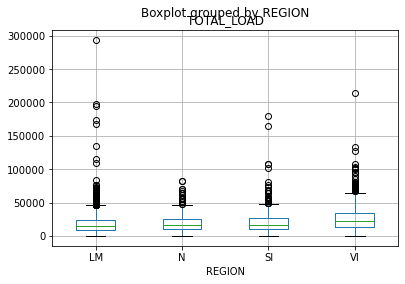

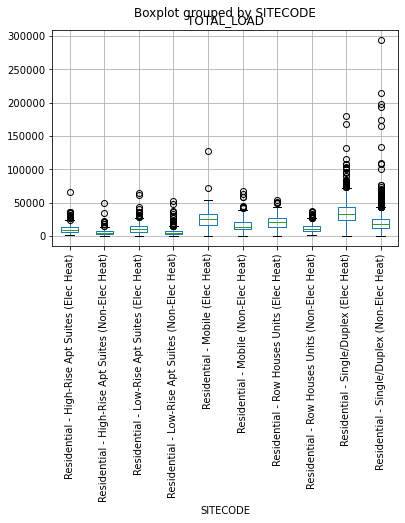

In [10]:
df_meta.boxplot("TOTAL_LOAD", by='REGION')
df_meta.boxplot("TOTAL_LOAD", by='SITECODE')
plt.xticks(rotation=90);

### No we'll construct the dataframe w/ all of the hourly data. 
The first column will be the datetime (data + hr of the day)
The next columns will be the House ID

In [11]:
start_date = df.DATE.unique().min()
end_date = df.DATE.unique().max() + np.timedelta64(1,'D')
datetimes = pd.date_range(start=start_date,end=end_date,freq='H',closed='left')
data_dic = {'DATE':datetimes}
for house_id in df.ID.unique():
    _data = df[df.ID == house_id][Hours].values
    _data = _data.flatten()
    data_dic[str(house_id)] = _data
   
df_data = pd.DataFrame.from_dict(data_dic)
df_data.head()

,DATE,1,2,3,4,5,6,7,8,9,...,5154,5155,5156,5157,5158,5159,5160,5161,5162,5163
0,2015-11-01 00:00:00,1.364,0.512,0.107,1.178,0.759,0.653,0.218,1.162,0.936,...,0.086,0.813,0.484,2.745,0.406,0.851,0.161,0.992,1.193,1.878
1,2015-11-01 01:00:00,1.360,0.411,0.108,1.887,0.613,0.397,0.375,0.845,0.805,...,0.094,0.533,0.379,2.716,0.724,0.107,0.166,0.999,1.137,1.036
2,2015-11-01 02:00:00,1.341,0.395,0.116,1.144,0.623,0.309,0.372,0.421,0.804,...,0.094,0.581,0.579,2.689,0.634,0.106,0.160,1.003,1.198,2.002
3,2015-11-01 03:00:00,1.398,0.363,0.106,1.144,0.623,0.348,0.128,0.422,0.768,...,0.093,1.191,0.447,2.565,0.602,0.107,0.173,0.995,1.214,1.746
4,2015-11-01 04:00:00,1.471,0.339,0.094,1.423,0.610,0.336,0.312,0.465,0.615,...,0.094,0.543,0.501,2.466,0.484,0.383,0.177,0.998,1.276,2.338


### Great, so no we've got df_data and df_meta. We can safely remove df from memory to free up some space.

 The next step is to remove any houses from the data set that we feel should be. Let's remove houses that have PV and houses that have exceptionally high power draws, perhaps from an EV.


In [12]:
PV_IDs = df_meta.ID[df_meta.MIN_LOAD<-0.01].values
EV_IDs = df_meta.ID[df_meta.MAX_LOAD>15].values
IDs_to_delete = list(set(PV_IDs) | set(EV_IDs))
IDs_to_delete = [str(_) for _ in IDs_to_delete]
print('Deleting the following IDs: ', IDs_to_delete)

Deleting the following IDs:  ['1', '4098', '5123', '4100', '5128', '9', '5129', '4109', '2073', '1057', '5153', '1060', '1062', '2092', '45', '1072', '3122', '4146', '4150', '4158', '2111', '3136', '1090', '1097', '74', '2122', '4170', '78', '3156', '95', '1122', '1123', '4198', '4199', '106', '111', '2160', '3183', '1140', '3190', '2167', '3194', '1147', '4227', '3216', '2195', '4249', '3229', '2206', '4254', '1188', '4260', '1191', '2217', '4266', '1208', '3259', '1221', '2248', '4304', '2257', '3284', '1240', '217', '1245', '4320', '1252', '3301', '2278', '3306', '2286', '4337', '2291', '2292', '1271', '247', '2297', '4346', '251', '1276', '2300', '2302', '4351', '4357', '4360', '3339', '268', '4364', '2320', '2325', '3349', '4380', '4386', '1321', '299', '306', '2359', '318', '3394', '2373', '3404', '2381', '338', '2389', '347', '356', '358', '4457', '2411', '1397', '3445', '1404', '2432', '4480', '2436', '2442', '1419', '3470', '406', '2454', '3479', '4514', '4516', '421', '2470',

In [13]:
df_data = df_data.drop(columns = IDs_to_delete)
df_meta = df_meta[~(df_meta.ID.isin(IDs_to_delete))]

In [14]:
del df

# Temperature Data

### I've already done the work in creating these files... 
For each region, I took the 5 or so most populous cities and downloaded their hourly temperature data. I then took  a population weighted average to compute a temperature profile for each region. Let's load those into a dataframe...


In [15]:
for i, r in enumerate(df_meta.REGION.unique()):
    filename = './Data/TemperatureDataFrame_'+r+'.csv'
    _df = pd.read_csv(filename)
    for col in _df.columns:
        if 'Unnamed' in col:
            _df = _df.drop(columns=col)
    _df['DATE'] = pd.to_datetime(_df.DATE)
    _df = _df.rename(columns={"TEMP":r})
    if i == 0:
        dfT = _df
    else:
        dfT[r] = _df[r]

#dfT = dfT[(dfT.DATE >= df.DATE.min()) & (dfT.DATE < df.DATE.max() + datetime.timedelta(days=1))]
dfT.head()

,DATE,VI,LM,SI,N
0,2015-10-30 00:00:00,11.324404,11.4,7.938208,5.8
1,2015-10-30 01:00:00,11.318192,11.3,8.275406,6.1
2,2015-10-30 02:00:00,11.658391,11.1,7.744562,6.3
3,2015-10-30 03:00:00,11.438503,10.9,7.978351,6.3
4,2015-10-30 04:00:00,11.228983,11.1,7.815028,5.6


# Electric Heating Demand
### From the demand data, we want to extract the electric heating demand.
This (sometimes referred to as load disaggregation) is not easy. We will not pretend to do a good job here. This is just to get a flavour for the problem. 

Here's what we'll do to calculate the electric heating demand for house H:
- partition the year into times when the heating is likely on (T_H), and the times when the heating (and AC!) is likely off (T_NH)
- for each hour in T_NH, assume heating demand HD = 0.
- for each hour in T_N, assume the heating demand is the hourly load minus the average load for all loads in T_NH for that hour and that day of the week. 

Again, I can't stress enough that this is just to give us something to play with... More sophisticaed ways to extract heating demands exist.

We'll do this in detail for one house. But first, let's get rid of all the non heating houses...


**Note: have a look at https://www.sciencedirect.com/science/article/abs/pii/S0306261920302270. This is work done by Dr. Evins and his group on this very data set. They are more knowledgable than I am.


In [16]:
non_elec_IDs = df_meta[df_meta['SITECODE'].str.contains("Non-Elec")].ID
non_elec_IDs = [str(_) for _ in non_elec_IDs]
df_meta = df_meta[~(df_meta['ID'].isin(non_elec_IDs))]
df_data = df_data.drop(columns=non_elec_IDs)
df_meta.SITECODE.unique()

['Residential - Low-Rise Apt Suites (Elec Heat)', 'Residential - Single/Duplex (Elec Heat)', 'Residential - High-Rise Apt Suites (Elec Heat)', 'Residential - Row Houses Units (Elec Heat)', 'Residential - Mobile (Elec Heat)']
Categories (5, object): ['Residential - Low-Rise Apt Suites (Elec Heat)', 'Residential - Single/Duplex (Elec Heat)', 'Residential - High-Rise Apt Suites (Elec Heat)', 'Residential - Row Houses Units (Elec Heat)', 'Residential - Mobile (Elec Heat)']

Arlight, let's calculate that heating demand for the first house...

We could use a changepoint method or something of the like for each house to determine at which temperature their heating system kicks in, but we won't bother for now (I've done a really simply mock up of this in the following cell... just to give you an idea). Instead, we'll just assume 16 deg C. Note, this doesn't account for houses w/ AC (which will conflate results etc...).

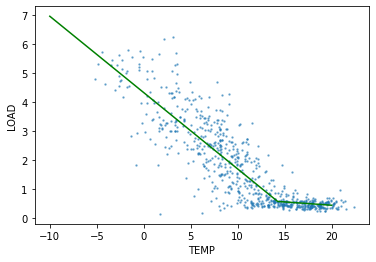

In [17]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])
thresholds = []
for i, house in enumerate(df_meta.ID.unique()):
    region = df_meta[df_meta.ID == house].REGION.values[0]
    temp_df = dfT[['DATE', region]]
    load_df = df_data[['DATE', str(house)]]
    _df = pd.merge(temp_df, load_df, on='DATE')
    _df.rename(columns={region:'TEMP', str(house):'LOAD'}, inplace=True)
    _df = _df.reset_index().set_index('DATE')
    _df_daily_means = _df.resample(rule='D').mean()
    x = _df_daily_means.TEMP.values
    y = _df_daily_means.LOAD.values
    p, e = optimize.curve_fit(piecewise_linear, x, y)
    new_x = np.linspace(-10, 20, 100)
    fit = piecewise_linear(new_x, *p)
    threshold = p[0]
    thresholds.append(threshold)
    if i == 0:
        _df_daily_means.plot.scatter(x='TEMP', y='LOAD', s=2, alpha = 0.5)
        plt.plot(new_x, fit, c='g')
        break

So what we'll do is just make a data frame similar to df_load but it will be our calculated heating load. This is going to take a while to process. Now is a good time to have a snack... here goes...
    

In [18]:
threshold = 16

# this will be the data frame w/ the electric heat load data.
# we'll make it the same shape/form as df_data, but zero all the values.
df_elec_heat = copy.copy(df_data).reset_index(drop=True).set_index('DATE')
df_elec_heat[df_elec_heat.columns] = 0
n_houses = len(df_meta.ID.unique())
props = list(np.linspace(0,1,11))
for i, house in enumerate(df_meta.ID.unique()):
    if float(i)/float(n_houses) > props[0]:
        print('{}% of houses processed...'.format(int(props[0]*100)))
        props = props[1:]
   
    region = df_meta[df_meta.ID == house].REGION.values[0]
    temp_df = dfT[['DATE', region]]
    load_df = df_data[['DATE', str(house)]]
    _df = pd.merge(temp_df, load_df, on='DATE')
    _df = _df.reset_index(drop=True).set_index('DATE')
    _df_heat = _df[_df[region] < threshold]
    _df_nonheat = _df[_df[region] >= threshold]
    # the next line of code calculates the average non heating load per day of the week, e.g. M,T,W,...,Sun
    _df_nonheat_avgs = _df_nonheat.groupby(_df_nonheat.index.strftime('%A %H:%M')).mean()

    # There is a chance here that there are no occurences for a day/hour combination where the temp is
    # above the threshold (e.g. at 3 am in the North region. Let's just assume 0 for those cases since
    # they're more than likely in the middle of the night.)
    if len(_df_nonheat_avgs) < 168:
        _zero_heat = _df.groupby(_df.index.strftime('%A %H:%M')).mean()
        _missing_dates = set(_zero_heat.index).difference(set(_df_nonheat_avgs.index))
        for _md in _missing_dates:
            _df_nonheat_avgs.loc[_md] = 0
        _df_nonheat_avgs.loc[list(_missing_dates)] = 0
        _df_nonheat_avgs = _df_nonheat_avgs.sort_index()
    # Now let's go through the hourly loads and extract the electric heating demand...
    # Note, there are much faster ways of doing this. But, we're just going to run it the one time
    # and save it into a datafile. From then on out we'll just read it in directly from the data file.
    # So I'm not going to bother coding it up that way. Just a heads up that this loop may take a while
    # to execute.
    elec_heat = []
    _df_heat['DayOfWeek'] = _df_heat.index.strftime('%A %H:%M')
    _df_heat['AvgLoad'] = 0

    for dow in _df_heat['DayOfWeek'].unique():
        _df_heat.loc[_df_heat['DayOfWeek'] == dow,'AvgLoad'] = \
             _df_nonheat_avgs[_df_nonheat_avgs.index == dow][str(house)].values[0]

    _df_heat['ElecHeat'] = (_df_heat[str(house)] - _df_heat['AvgLoad']).clip(lower=0)
    df_elec_heat.loc[_df_heat.index,str(house)] = _df_heat['ElecHeat'].values


0% of houses processed...
10% of houses processed...
20% of houses processed...
30% of houses processed...
40% of houses processed...
50% of houses processed...
60% of houses processed...
70% of houses processed...
80% of houses processed...
90% of houses processed...


Let's have a quick look at the first 10 houses electric heating loads...

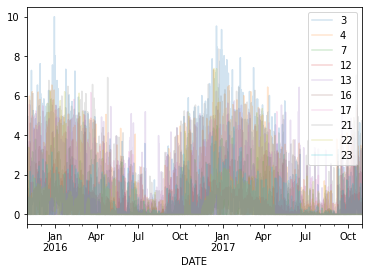

In [19]:
df_elec_heat[df_elec_heat.columns[:10]].plot.line(alpha=0.2);

Finally, let's save the dataframes to file. This way we won't have to repeat this process each time we want to analyze heating demands.

In [20]:
dfT = dfT.reset_index(drop=True).set_index('DATE')

In [21]:
dfT.to_csv('./Dataframes/Temperature_Dataframe.csv')
df_meta.to_csv('./Dataframes/Metadata_Dataframe.csv')
df_data.to_csv('./Dataframes/Load_Dataframe.csv')
df_elec_heat.to_csv('./Dataframes/ElecHeat_Dataframe.csv')